<a href="https://colab.research.google.com/github/lucash-h/MNIST_GAN/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import time
from tensorflow.keras import layers
import time
from tensorflow.keras.layers import Dense, Conv2D, Dropout, LeakyReLU, Flatten, Reshape, BatchNormalization, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

In [22]:
#Variables
batch_size = 32
epochs = 5

latent_dimension = 100
noise_dimension = 100

generator_learning_rate = 0.001
discriminator_learning_rate = 0.001

In [23]:
loss_dict = {'generator_loss':[],
             'discriminator_loss':[],
             'real_discriminator_loss':[],
             'fake_discriminator_loss':[],
             'real_discriminator_acc':[],
             'fake_discriminator_acc':[]}

In [24]:
(real_images, real_labels), (test_set,test_set_labels) = tf.keras.datasets.mnist.load_data()

assert real_images.shape == (60000, 28, 28)
assert real_labels.shape == (60000,)

assert test_set.shape == (10000, 28, 28)
assert test_set_labels.shape == (10000,)



real_images = real_images / 255.0
test_set = test_set / 255.0

real_images = tf.reshape(real_images,(-1,batch_size,28,28,1))

In [25]:
def build_generator(latent_dimension):
  xin = Input((latent_dimension))
  xout = Dense(7*7*128, input_dim = latent_dimension)(xin) #map input noise to higher dimension
  xout = Reshape((7,7,128))(xout) #reshape so suitable for convolution
  xout = BatchNormalization()(xout) #normalizes
  xout = LeakyReLU(alpha=0.2)(xout) #non linearity
  xout = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(xout) #generate higher res
  xout = BatchNormalization()(xout)
  xout = LeakyReLU(alpha=0.2)(xout)
  xout = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')(xout) #tanh provides higher res -1 -> 1 rather than 0 -> 1 and vals are centered @ 0 for other layers
  return Model(xin,xout)

In [26]:
def build_discriminator():
    xin = Input((28,28,1))
    xout = Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1))(xin)
    xout = LeakyReLU(alpha=0.2)(xout)
    xout = Dropout(0.4)(xout)
    xout = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(xout)
    xout = LeakyReLU(alpha=0.2)(xout)
    xout = Dropout(0.4)(xout)
    xout = Flatten()(xout)
    xout = Dense(1, activation='sigmoid')(xout) #sets vals 0-1 --> fake - real

    return Model(xin,xout)

In [27]:
generator = build_generator(latent_dimension)
#generator.compile(optimizer='Adam', loss = 'bce')
generator.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_4 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 batch_normalization_4 (Bat  (None, 7, 7, 128)         512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 14, 14, 128)       262272    
 Transpose)                                                

In [28]:
discriminator = build_discriminator()
#discriminator.compile(optimizer='Adam', loss='bce', metrics=['accuracy'])
discriminator.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0   

In [29]:
discriminator.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [30]:
generator.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [31]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=generator_learning_rate)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=discriminator_learning_rate)

In [32]:
@tf.function
def train_step(images):
# Training loop
  noise = tf.random.normal([batch_size, noise_dimension])
  loss_log = {'generator_loss':[],'discriminator_loss':[], 'real_discriminator_loss':[], 'fake_discriminator_loss':[]} #, 'real_disc_acc':[], 'fake_disc_acc':[]}

  with tf.GradientTape() as gen_tape:
    generated_images = generator(noise)

    fake_output = discriminator(generated_images)
    generator_loss = bce(tf.ones(batch_size),fake_output)
    loss_log['generator_loss'].append(generator_loss)


  gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
  gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  with tf.GradientTape() as disc_tape:
    real_output = discriminator(images)
    fake_output = discriminator(generated_images)

    fake_discriminator_loss = bce(tf.zeros(batch_size),fake_output)
    loss_log['fake_discriminator_loss'].append(fake_discriminator_loss)

    real_discriminator_loss = bce(tf.ones(batch_size),real_output)
    loss_log['real_discriminator_loss'].append(real_discriminator_loss)

    total_discriminator_loss = fake_discriminator_loss + real_discriminator_loss
    loss_log['discriminator_loss'].append(total_discriminator_loss)

  gradients_of_discriminator = disc_tape.gradient(total_discriminator_loss, discriminator.trainable_variables)
  disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



  return loss_log

In [33]:
#split test set into batches of 32
num_batches = len(test_set) // batch_size
split_indices = [i * batch_size for i in range(1, num_batches)]
test_set_batched = np.split(test_set, split_indices)

print(len(test_set_batched))


for epoch in range(epochs):
  for batch in tqdm(real_images):
    batch_loss = train_step(batch)

    for key in batch_loss:
      loss_dict[key].append(batch_loss[key])
  #add accuracy
  batch_index = np.random.randint(0, 311) #chooses random int value from 0 to 311 to pull random batch from test set
  result_real_eval = discriminator.evaluate(x=test_set_batched[batch_index],
                                  y=tf.ones(32),
                                  verbose = 0)

  result_gen_eval = discriminator.evaluate(x=generator(tf.random.normal([batch_size, noise_dimension])),
                                  y=tf.zeros(32),
                                  verbose = 0)

  loss_dict['real_discriminator_acc'].append(result_real_eval[1]) #index 0 is loss, index 1 is accuracy
  loss_dict['fake_discriminator_acc'].append(result_gen_eval[1])

312


100%|██████████| 1875/1875 [04:23<00:00,  7.13it/s]


In [34]:
def show_images(sample_number, images):

    _edge_length = int(np.sqrt(sample_number))
    fig,ax = plt.subplots(nrows = _edge_length, ncols = _edge_length,figsize=(10,10))
    for i in range(_edge_length**2):
        ax[i//_edge_length][i%_edge_length].imshow(images[i, :, :, 0])
        ax[i//8][i%8].axis('off')

In [35]:
n_generated_samples = 64
generated = generator(tf.random.normal((n_generated_samples,100)))

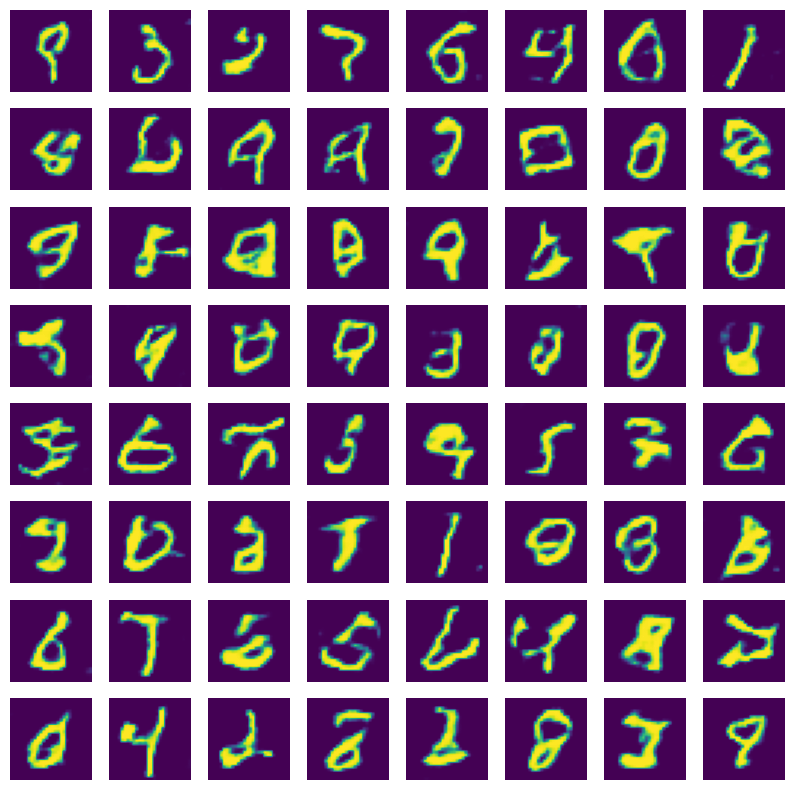

In [36]:
show_images(n_generated_samples, generated)

In [41]:
def plot_metrics(list1,list1_title, list2, list2_title, downsample=False, ds_value=1, x_title='X', y_title='Y', plot_title='Plot'):

    if downsample == True:
        list1 = list1[::ds_value]
        list2 = list2[::ds_value]

    plt.figure().set_figwidth(15)
    plt.grid(True)

    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(plot_title)

    plt.plot(list1, label=list1_title)
    plt.plot(list2, label=list2_title)

    plt.legend()
    plt.show()

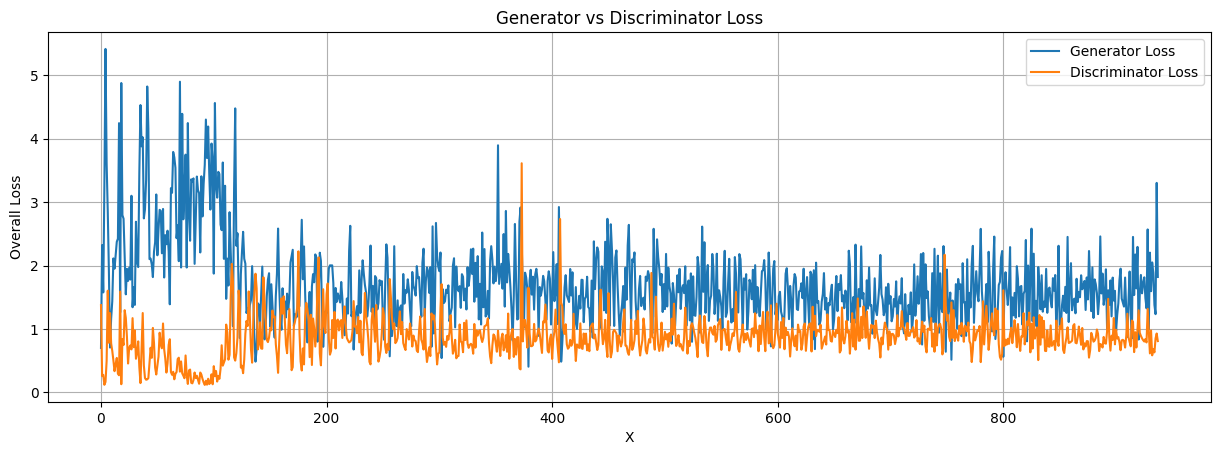

In [42]:
plot_metrics(loss_dict['generator_loss'],
              'Generator Loss',
              loss_dict['discriminator_loss'],
              'Discriminator Loss',
              True,
              10,
              'X',
              'Overall Loss',
              'Generator vs Discriminator Loss')


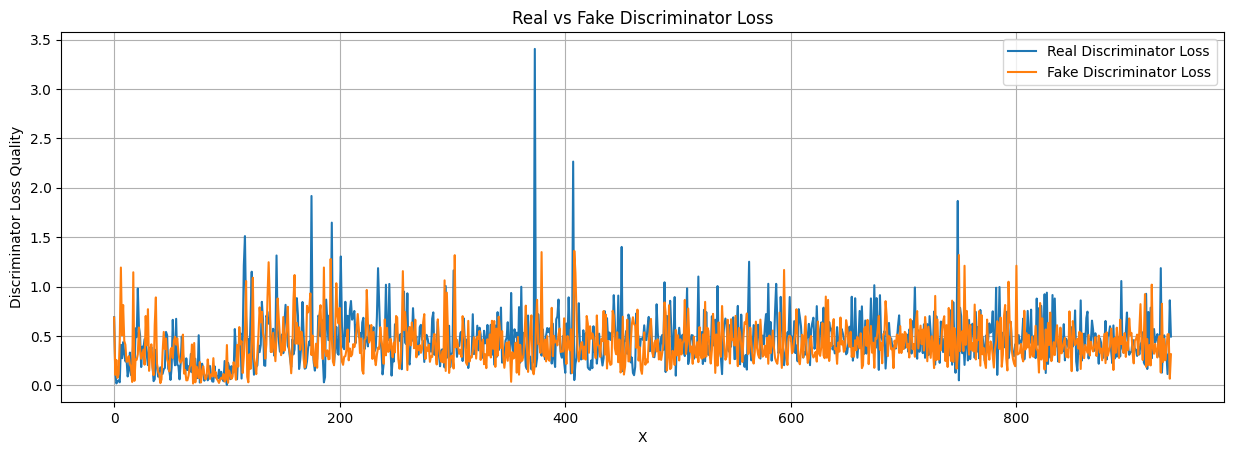

In [43]:
plot_metrics(loss_dict['real_discriminator_loss'],
              'Real Discriminator Loss',
              loss_dict['fake_discriminator_loss'],
              'Fake Discriminator Loss',
              True,
              10,
              'X',
              'Discriminator Loss Quality',
              'Real vs Fake Discriminator Loss')

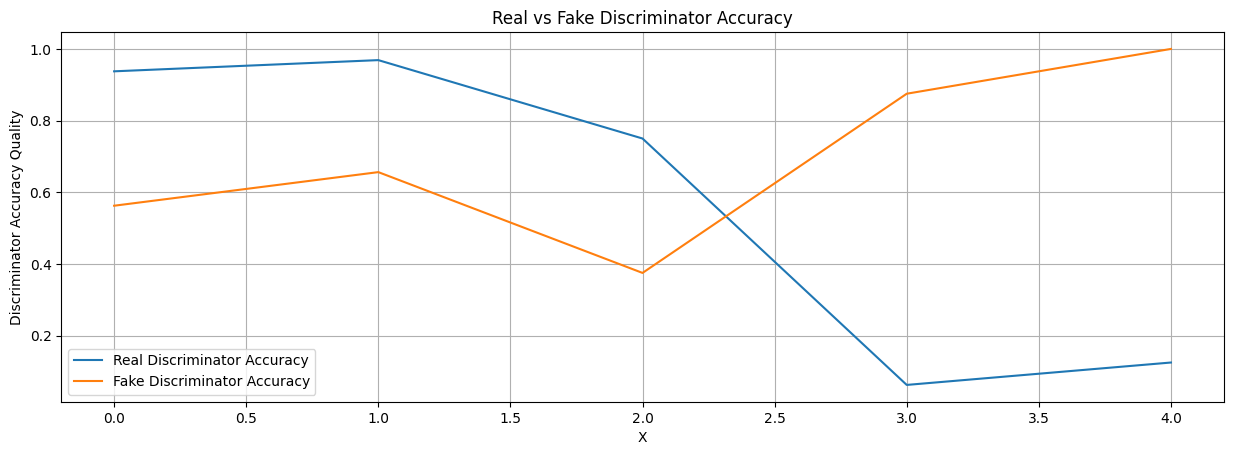

In [44]:
plot_metrics(loss_dict['real_discriminator_acc'],
              'Real Discriminator Accuracy',
              loss_dict['fake_discriminator_acc'],
              'Fake Discriminator Accuracy',
              False,
              10,
              'X',
              'Discriminator Accuracy Quality',
              'Real vs Fake Discriminator Accuracy')